# Tutorial: data integration for simulated data with specific cluster

## load package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_4dim, fgot_tol, align
from FGOT import metrics as mt

## Load data

In [3]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/simulated_data2/"
batch1 = pd.read_csv(data_path+"Batch1_feature50_selected_data.txt", sep='\t',index_col=0)
batch2 = pd.read_csv(data_path+"Batch2_feature50_selected_data.txt", sep='\t',index_col=0)

cell1_cluster = pd.read_csv(data_path+"simulation2_label1.txt", sep='\t').rename(columns={'x': 'cluster'})
cell2_cluster = pd.read_csv(data_path+"simulation2_label2.txt", sep='\t').rename(columns={'x': 'cluster'})
cell1_cluster.insert(0, 'cell', list(batch1.columns))
cell2_cluster.insert(0, 'cell', list(batch2.columns))
cell1_cluster = cell1_cluster.reset_index(drop=True)
cell2_cluster = cell2_cluster.reset_index(drop=True)

In [4]:
X1 = batch1.T
X2 = batch2.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(cell1_cluster['cluster'])
basic_labels2 = np.array(cell2_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(batch1.columns)
cell_names2 = list(batch2.columns)
gene_names1 =list(batch1.index)
gene_names2 =list(batch2.index)

Dimensions of input datasets are:  X1 =  (500, 73)  X2 =  (545, 73)
Dimensions of basic_labels are:  basic_labels1 =  (500,)  basic_labels2 =  (545,)


## Compute feature relationship

In [5]:
markers1 = pd.read_csv(data_path+"Batch1_marker_genes.txt", sep='\t',index_col=0)
markers2 = pd.read_csv(data_path+"Batch2_marker_genes.txt", sep='\t',index_col=0)
group_affinity = pre.calculate_group_affinity(markers1,markers2)
match_cluster = pd.DataFrame(group_affinity.idxmax(axis=1),columns=['Batch2'])
match_cluster

,Batch2
Group3,Group3
Group2,Group2


In [6]:
top10genes1 = pd.read_csv(data_path+"Batch1_top50_marker_genes.txt", sep='\t')
top10genes2 = pd.read_csv(data_path+"Batch2_top50_marker_genes.txt", sep='\t')
feature_matrix = pd.DataFrame(np.inf, index=batch1.index, columns=batch2.index)
for gene1 in feature_matrix.index:
    for gene2 in feature_matrix.columns:
        group1 = top10genes1[top10genes1['gene']==gene1].cluster.tolist()
        group2 = top10genes2[top10genes2['gene']==gene2].cluster.tolist()
        for i in group1:
            if i not in group2:
                continue
            for j in group2:
                if match_cluster.loc[i].Batch2 == j:
                    feature_matrix.loc[gene1,gene2] = 1

In [7]:
feature_matrix.shape

(73, 73)

## Compute cost
Calculate the similarity between cells through MNN pairs.

In [8]:
cell_Cor = pre.calculate_cell_similarity_byMNN(X1,X2,cell_names1,cell_names2,scale=0,knn = 20)


the number of MNN pairs is  2692


In [9]:
S_new = pre.smooth_cell_similarity_byLaplacian1(cell_Cor,X1,X2)
S_new = S_new/np.max(S_new) + cell_Cor/np.max(cell_Cor)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# compute cost
cost = np.array(np.exp(np.max(S_new) - S_new))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

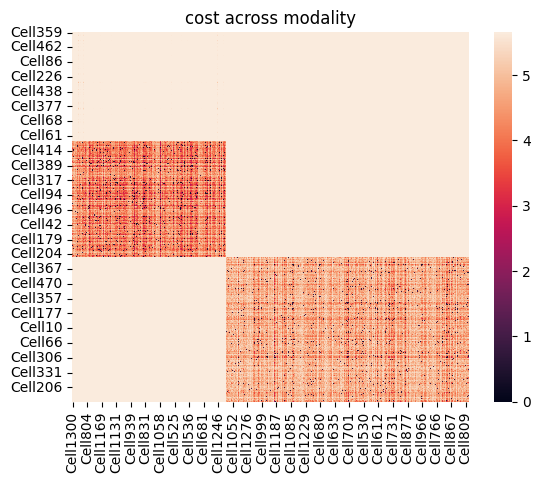

In [11]:
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_rows]
sns.heatmap(sorted_cost)
pl.title('cost across modality')

## scale

In [12]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=gene_names1)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names2)

## solve the feature-guided optimal transport

In [13]:
P_4dim = FGOT.fgot.fgot_sparse_4dim(X1, X2, feature_matrix, cost,\
    minibatch=0, device='cuda:5', eps_p = 6e-2,rho = 0)

minibatch = 0 and device =  cuda:5


In [14]:
P = fgot_tol(P_4dim)
P.shape

100%|██████████| 2482/2482 [00:00<00:00, 2703.44it/s]


(500, 545)

Text(0.5, 1.0, 'optimal transport matrix')

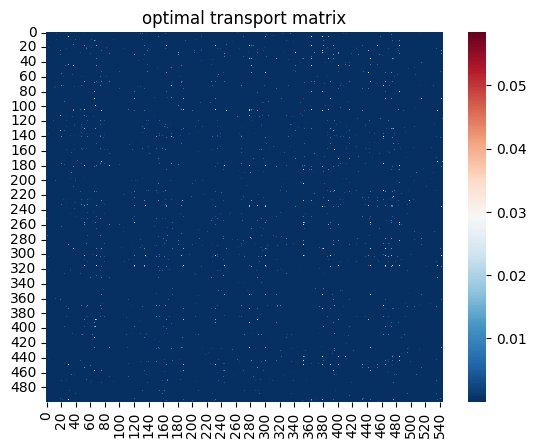

In [15]:
sns.heatmap(P, cmap="RdBu_r")
pl.title('optimal transport matrix')

Text(0.5, 1.0, 'optimal transport matrix across modality')

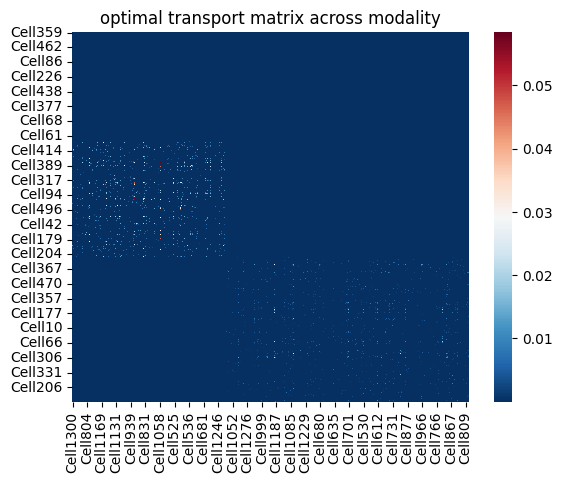

In [16]:
p = pd.DataFrame(P,index= cell_names1,columns=cell_names2)
sorted_cols = np.argsort(basic_labels1)
sorted_cost = p.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_rows]
sns.heatmap(sorted_cost, cmap="RdBu_r")
pl.title('optimal transport matrix across modality')

In [17]:
X1_aligned, X2_aligned = align(X1, X2, P)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

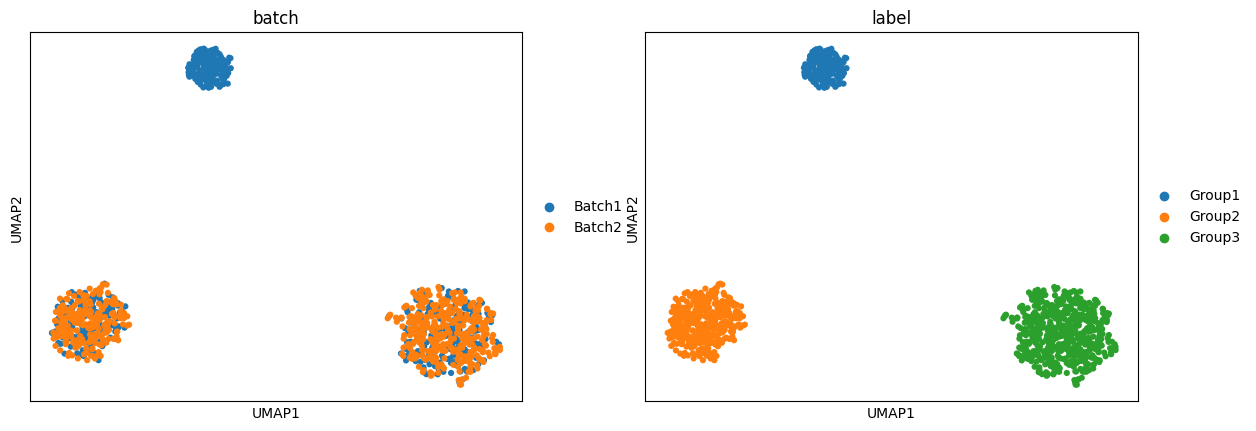

In [18]:
data_aligned = np.concatenate((X1_aligned,X2_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['Batch1'] * n1 + ['Batch2'] * n2)
adata_aligned.obs['label'] = np.concatenate((basic_labels1,basic_labels2), axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80)